In [1]:
!pip install pygame

In [1]:
!pip install numpy==1.23.0  # This restarts the runtime to apply the new NumPy version


In [5]:
!pip install gym

In [5]:
!pip install numpy==1.23.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 58.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.23.0-cp311-cp311-linux_x86_64.whl size=19730252 sha256=4cc9ca12db19aa5ae2d260ee34f9a048d209033f5d83a710f8c24ab6578f4dc0
  Stored in directory: /root/.cache/pip/wheels/6d/36/1a/3ec6b85008bea3151efb003f5d41baa7bf4966cb43c1c2470b
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.0 which is incompatible.
scipy 1.14.1 requires numpy<2.3,>=1.23.5, but you have numpy 1.23.0 which is i

In [6]:
!pip install Box2D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 7.6 MB/s eta 0:00:00


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import random
import numpy as np
import gym
import gym.spaces as sp
from tqdm import trange
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#%% Policy network
class QNet(nn.Module):
    # Policy Network
    def __init__(self, n_states, n_actions, n_hidden=64):
        super(QNet, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(n_states, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_actions)
            )

    def forward(self, x):
        return self.fc(x)

#%% dqn
class DQN():
    def __init__(self, n_states, n_actions, batch_size=64, lr=1e-4, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=1e-3):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau

        # model
        self.net_eval = QNet(n_states, n_actions).to(device)
        self.net_target = QNet(n_states, n_actions).to(device)
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # memory
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
        self.counter = 0    # update cycle counter

    def getAction(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.net_eval.eval()
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()

        # epsilon-greedy
        if random.random() < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            action = np.argmax(action_values.cpu().data.numpy())

        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones)          # target, if terminal then y_j = rewards
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network
        self.softUpdate()

    def softUpdate(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*eval_param.data + (1.0-self.tau)*target_param.data)


class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

In [2]:
def train(env, agent, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=200, chkpt=False):
    score_hist = []
    epsilon = eps_start

    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    # bar_format = '{l_bar}{bar:10}{r_bar}'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)
    for idx_epi in pbar:
        state = env.reset()
        score = 0
        for idx_step in range(max_steps):
            action = agent.getAction(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.save2memory(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break

        score_hist.append(score)
        score_avg = np.mean(score_hist[-100:])
        epsilon = max(eps_end, epsilon*eps_decay)

        pbar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
        pbar.update(0)

        # if (idx_epi+1) % 100 == 0:
        #     print(" ")
        #     sleep(0.1)

        # Early stop
        if len(score_hist) >= 100:
            if score_avg >= target:
                break

    if (idx_epi+1) < n_episodes:
        print("\nTarget Reached!")
    else:
        print("\nDone!")

    if chkpt:
        torch.save(agent.net_eval.state_dict(), 'checkpoint.pth')

    return score_hist

#%% Test Lunar Lander
def testLander(env, agent, loop=3):
    for i in range(loop):
        state = env.reset()
        for idx_step in range(500):
            action = agent.getAction(state, epsilon=0)
            env.render()
            state, reward, done, _ = env.step(action)
            if done:
                break
    env.close()

def plotScore(scores):
    plt.figure()
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episodes")
    plt.show()

In [12]:
BATCH_SIZE = 128           # Good size for faster GPU computation
LR = 3e-4                  # Balanced LR for faster convergence without overshooting
EPISODES = 1500            # Reduced slightly to encourage faster runs; can stop early via TARGET_SCORE
TARGET_SCORE = 250.        # Standard solve threshold
GAMMA = 0.98               # Slightly lower for quicker reward propagation
MEMORY_SIZE = 50000        # Large enough to generalize but not so big it slows down sampling
LEARN_STEP = 2             # More frequent updates without being too aggressive
TAU = 1e-2                 # Quicker soft update for target network
SAVE_CHKPT = True         # Enable if you want to resume or analyze best models


In [20]:
state, info = env.reset()

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
 38%|###8      |  571/1500 [  17:20<  28:12,  1.82s/ep, Score:  306.11, 100 score avg:  250.96]



Target Reached!


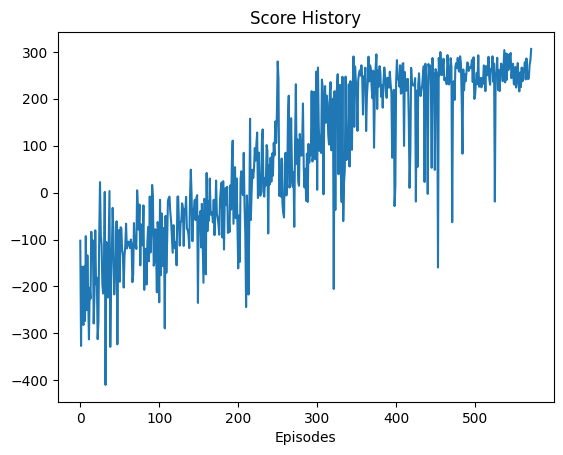

In [13]:
env = gym.make('LunarLander-v2')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

agent = DQN(
    n_states=num_states,
    n_actions=num_actions,
    batch_size=BATCH_SIZE,
    lr=LR,
    gamma=GAMMA,
    mem_size=MEMORY_SIZE,
    learn_step=LEARN_STEP,
    tau=TAU
)

# Make sure the train loop unpacks the reset properly
score_hist = train(env, agent, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
plotScore(score_hist)

if device.type == "cuda":
    torch.cuda.empty_cache()


In [21]:
import torch

weights_filename = "/content/dqn_lander_weights_20250416-155933.pth"

agent.net_eval.load_state_dict(torch.load(weights_filename, map_location=device))
agent.net_eval.eval()

print(f"✅ Loaded weights from {weights_filename}")



✅ Loaded weights from /content/dqn_lander_weights_20250416-155933.pth


In [22]:
def testLander(agent, loop=10):
    for i in range(loop):
        env = gym.make("LunarLander-v2")  # create fresh env
        state = env.reset()
        done = False
        score = 0
        while not done:
            env.render(mode="rgb_array")  # use rgb_array if headless
            action = agent.getAction(state, epsilon=0)
            state, reward, done, _ = env.step(action)
            score += reward
        print(f"Episode {i + 1}, Score: {score}")
        env.close()


Run code below to save tested results into a gif!   
Saved gifs will appear in `gifs` folder.

In [19]:
import torch
import time
from google.colab import files

# Step 1: Save model weights with a timestamp
timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"dqn_lander_weights_{timestamp}.pth"
torch.save(agent.net_eval.state_dict(), filename)

# Step 2: Download the file to your local machine
files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
import os
import imageio
from PIL import Image, ImageDraw, ImageFont

def TextOnImg(img, score):
    img = Image.fromarray(img)
    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 18)  # Commonly available in Colab
    except:
        font = ImageFont.load_default()  # Fallback to default
    draw = ImageDraw.Draw(img)
    draw.text((20, 20), f"Score={score: .2f}", font=font, fill=(255, 255, 255))
    return np.array(img)


    return np.array(img)

def save_frames_as_gif(frames, filename, path="/content/"):
    if not os.path.exists(path):
        os.makedirs(path)

    print("Saving gif...", end="")
    imageio.mimsave(path + filename + ".gif", frames, fps=60)
    print("Done!")


def gym2gif(env, agent, filename="gym_animation", loop=3):
    frames = []
    for i in range(loop):
        state = env.reset()
        score = 0
        for idx_step in range(500):
            frame = env.render(mode="rgb_array")
            frames.append(TextOnImg(frame, score))
            action = agent.getAction(state, epsilon=0)
            state, reward, done, _ = env.step(action)
            score += reward
            if done:
                break
    env.close()
    save_frames_as_gif(frames, filename=filename)

gym2gif(env, agent, loop=5)

from google.colab import files
files.download("/content/gym_animation.gif")


Saving gif...Done!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>